<a href="https://www.kaggle.com/code/garvit9/pnemunia-prediction?scriptVersionId=92720332" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
data_dir='../input/chest-xray-covid19-pneumonia/Data/train'

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5144 files belonging to 3 classes.
Using 4116 files for training.


2022-04-11 13:22:03.959084: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5144 files belonging to 3 classes.
Using 1028 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['COVID19', 'NORMAL', 'PNEUMONIA']


2022-04-11 13:22:04.828032: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


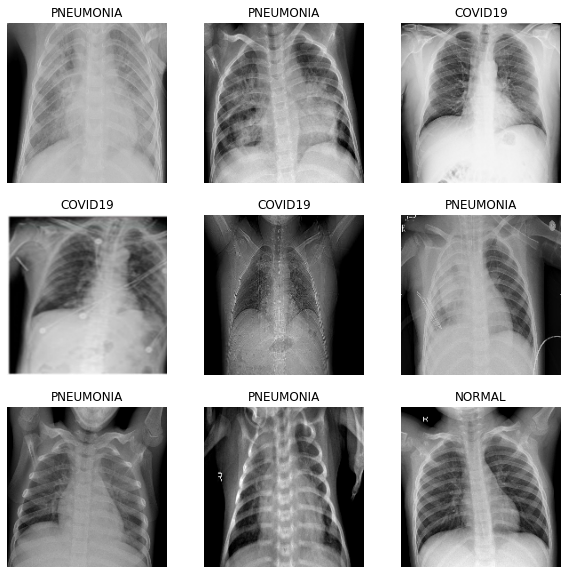

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [12]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2022-04-11 13:22:18.971184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 45 of 1000
2022-04-11 13:22:28.938947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 87 of 1000
2022-04-11 13:22:36.322141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


129/129 [==============================] - 66s 291ms/step - loss: 0.3900 - accuracy: 0.8491 - val_loss: 0.2639 - val_accuracy: 0.9066
Epoch 2/10
129/129 [==============================] - 31s 242ms/step - loss: 0.2061 - accuracy: 0.9278 - val_loss: 0.1921 - val_accuracy: 0.9300
Epoch 3/10
129/129 [==============================] - 31s 243ms/step - loss: 0.1514 - accuracy: 0.9451 - val_loss: 0.2199 - val_accuracy: 0.9232
Epoch 4/10
129/129 [==============================] - 31s 244ms/step - loss: 0.1267 - accuracy: 0.9519 - val_loss: 0.1740 - val_accuracy: 0.9329
Epoch 5/10
129/129 [==============================] - 31s 243ms/step - loss: 0.0956 - accuracy: 0.9655 - val_loss: 0.1757 - val_accuracy: 0.9387
Epoch 6/10
129/129 [==============================] - 31s 241ms/step - loss: 0.0786 - accuracy: 0.9704 - val_loss: 0.2450 - val_accuracy: 0.9202
Epoch 7/10
129/129 [==============================] - 31s 240ms/step - loss: 0.0600 - accuracy: 0.9764 - val_loss: 0.1869 - val_accuracy: 0.9

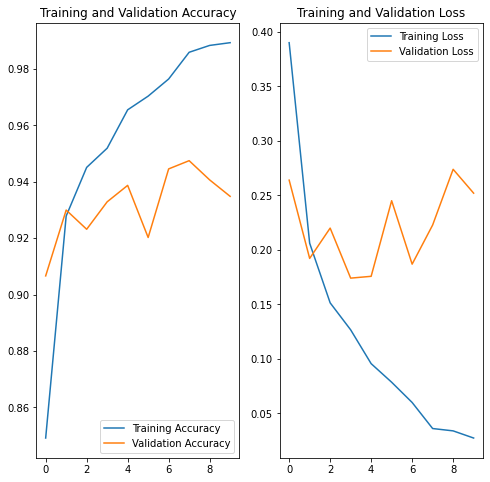

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
import glob
test_data = glob.glob('../input/chest-xray-covid19-pneumonia/Data/test/**/*.jpg')
print(len(test_data))
X,Y=[],[]
for path in test_data:
    img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) 
    tag=path.split('/')[-2]
    classes={'COVID19':0, 'NORMAL':1, 'PNEUMONIA':2}
    label=classes[tag]
    X.append(img_array)
    Y.append(label)

1288


In [15]:
def predict(img_array):
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    return np.argmax(score)

y_true=Y
y_pred=[predict(i) for i in X]

In [16]:
#accuracy_test_data
count=0
for i in range(len(y_true)):
    if y_true[i]==y_pred[i]: count+=1
print(count/len(y_true)*100)

94.64285714285714


<AxesSubplot:>

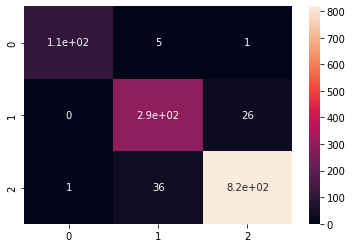

In [17]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)